# Machine Learning Analysis of HELOC Data

### By Tracy Lee, Alexander Nel,  Siu Kwan Ng and Hoi Lam Lee

### Introduction

In the field of machine learning, the need for models that are both accurate and interpretable is essential, especially in finance. This notebook focuses on building an Interpretable Machine Learning (IML) model using the Home Equity Line of Credit (HELOC) dataset.

We aim to achieve high prediction accuracy while providing clear explanations for the model's decisions. To accomplish this, we will utilize techniques such as feature importance measures and SHAP (SHapley Additive exPlanations) values. These methods will help us understand how different features influence credit risk and borrowing behavior.

By the end of this analysis, we will highlight the significance of model interpretability in making informed decisions based on the HELOC data.

In [1]:
# Import necessary package
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import *
from random import random, seed
from matplotlib import cm
import seaborn as sn
from scipy.stats import norm
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import SimpleImputer,IterativeImputer
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence as pdp
from sklearn import preprocessing
from pygam import LogisticGAM, s, f
import eli5
from eli5.sklearn import PermutationImportance
import pycebox.ice as icebox
import shap

warnings.filterwarnings('ignore')
%matplotlib inline

threshold = 0.5

In [2]:
# Load the training dataset
df = pd.read_csv('../data/HelocData.csv')
df = df.replace(to_replace =['Bad','Good'], value =[1,0])   # Bad = 1, Good = 0

In [3]:
# Split data
np.random.seed(20190009)
df_train,df_test = train_test_split(df, test_size=0.2)

Before modelling, our first step is to understand the distribution of missing values of the training dataset. We plot a bar chart to show the frequency of the missing values of different features.

### Step 1: Exploratory Data Analysis 

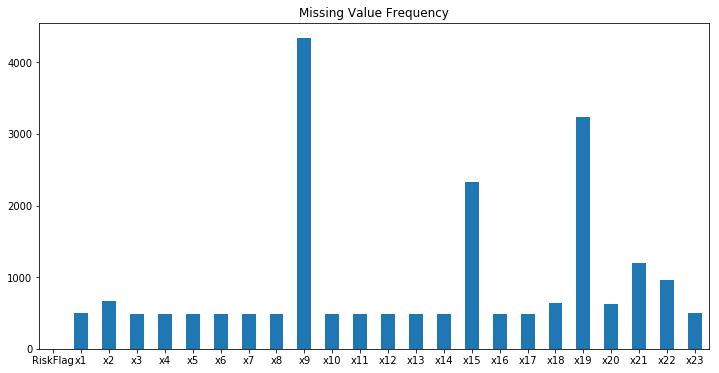

In [4]:
# (1): Plot a bar chart to understand the missing value frequency of each feature
df_train_copy = df_train.copy()
df_train_copy = df_train_copy.replace(to_replace =[-7,-8,-9], value =[np.nan,np.nan,np.nan])
missing_freq=df_train_copy.isnull().sum()
missing_freq.plot.bar(x='Variable', y='Frequency', rot=0, title='Missing Value Frequency', figsize=(12,6))
plt.show()

As shown in the above barplot, x9, x15 and x19 have an especially high frequency of missing values.

- The number of months since most recent delinquency, represented by x9, can be a missing value when the data is not available, or when no delinquency has occurred.

- The number of months since most recent inquiries excluding last 7  days, denoted by x15, can be a missing value when the data is not available, or when no inquries have ever been made.

- The net fraction installment burden, or x19, has also a high frequency of missing values, but the reason is not yet known at this stage.

We believe that the types of missing values could also be some important hints to the value of RiskFlag, so we further investigate these relationships for creating the following grouped barplots:

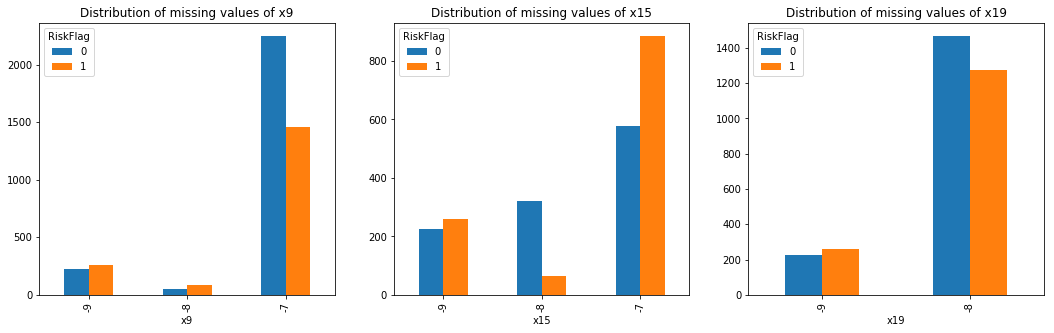

In [5]:
# (2) Plot the distribution of missing values of x9, x15 and x19
fig, axs = plt.subplots(1,3,figsize=(18,5))
df.iloc[df_train_copy[df_train_copy.loc[:,'x9'].isnull()].index,:].groupby('RiskFlag').x9.value_counts().unstack(0).plot.bar(title='Distribution of missing values of x9', ax=axs[0])
df.iloc[df_train_copy[df_train_copy.loc[:,'x15'].isnull()].index,:].groupby('RiskFlag').x15.value_counts().unstack(0).plot.bar(title='Distribution of missing values of x15', ax=axs[1])
df.iloc[df_train_copy[df_train_copy.loc[:,'x19'].isnull()].index,:].groupby('RiskFlag').x19.value_counts().unstack(0).plot.bar(title='Distribution of missing values of x19', ax=axs[2])
plt.show()

From the 3 barplots above, we conclude that the types of missing values of x9, x15 and x19 have siginificant effects on RiskFlag. Therefore, we would take this into consideration by adding additional features ('$x9\_neg7$', '$x9\_neg8$', '$x9\_neg9$', '$x15\_neg7$', '$x15\_neg8$', '$x15\_neg9$', '$x19\_neg8$', '$x19\_neg9$') in the next step.

Besides, after investigation, most of the time when a variable has value -9, all other variables of the record are -9. (There are 10 occurences in the training data where $x1=-9$ but other variables are not.) Therefore, '$x9\_neg9$', '$x15\_neg9$' and '$x18\_neg9$' are duplicates. Only '$x9\_neg9$' is kept as a consequence. We rename it as 'NoData'.

In [6]:
print('No. of -9 | No. of Occurrences in the training data\n',(df_train == -9).astype(int).sum(axis=1).value_counts())
df_train.loc[df_train['x1']==-9,:].loc[df_train['x2']!=-9,:]

No. of -9 | No. of Occurrences in the training data
 0     7871
23     486
1       10
dtype: int64


,RiskFlag,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23
6637,1,-9,92,82,87,2,0,0,100,-7,...,50,-7,0,0,-8,-8,-8,-8,-8,-8
2479,1,-9,115,55,78,3,0,0,100,-7,...,100,0,0,0,-8,-8,-8,-8,-8,-8
2398,0,-9,297,6,93,18,0,0,95,16,...,55,0,0,0,10,96,1,1,0,33
7634,1,-9,383,383,383,1,1,1,100,-7,...,100,-7,1,1,-8,-8,-8,-8,-8,-8
8158,1,-9,85,28,179,3,5,5,50,15,...,0,2,3,3,-8,-8,-8,-8,-8,-8
9419,0,-9,17,17,17,1,0,0,100,-7,...,100,0,0,0,-8,-8,-8,-8,-8,-8
3610,1,-9,87,10,35,18,1,1,89,3,...,16,0,2,2,29,73,6,1,1,47
2396,1,-9,175,159,167,2,1,1,100,-7,...,50,0,2,2,-8,-8,-8,-8,-8,-8
5537,1,-9,173,2,59,74,3,3,99,8,...,25,0,10,9,22,97,7,4,4,62
4205,1,-9,24,24,24,1,3,3,100,-7,...,100,3,1,1,-8,-8,-8,-8,-8,-8


The variables '$x6$' and '$x7$' represents the number of trades that last for 60+ days and 90+ days ever. These two variables are highly correlated since every trade that lasts for 90+days is counted in both '$x6$' and '$x7$'.

Similarly, the variables '$x16$' and '$x17$', which denote the number of inquries in the last 6 months including the last 7 days and excluding the last 7 days respectively, are also highly correlated.

To eliminate this problem, we propose the variable 'Number_Trades_60_To_90', which is the total number of trades that last for more than 60 and not more than 90 days, as well as 'Inq_last_7_days', which is the number of inquiries made in the last 7 days. On the other hand, the variables '$x6$' and '$x16$' will be dropped.

The variables '$x8$' and '$x9$' are slightly more complicated. x8 represents the percentage of trades which never go delinquent, while '$x9$' represents the number of months since the most recent delinquency. From the cell below, we can see that if 
$x8=100$, then $x9=-7$, however, $x9=-7$ does not necessarily imply $x8=100$, although this holds almost all cases except a few. In view of this situation, we should handle the imputation of missing values with care. For those cases with $x8!=100$ and $x9=-7$, they are identified as misclassified cases, so imputation of the x9 value in normal range ($0-9$) is carried out for these cases and $x9\_neg7$ will be set to 0. For those cases with $x8=100$ and $x9=-7$, $x9$ is set to the largest possible value. The maximum of $x9$ in the training data is chosen.

In [7]:
print('Given that x8=100, the value count of x9 is:\n', df_train.loc[df_train.x8==100,'x9'].value_counts())
print('\nGiven that x9=-7, the value count of x8 is:\n', df_train.loc[df_train.x9==-7,'x8'].value_counts())

Given that x8=100, the value count of x9 is:
 -7    3673
Name: x9, dtype: int64

Given that x9=-7, the value count of x8 is:
 100    3673
97       11
98        6
96        6
93        4
94        4
95        1
91        1
89        1
33        1
90        1
88        1
78        1
50        1
Name: x8, dtype: int64


It is known that '$x10$' and '$x11$' are categorical variables. One-hot encoding will thus be employed.

The variables '$x14*x19$' and '$(100-x14)*x18$' are also added. Here we assume that every trade are either installment trade or revolving trade. Since '$x14$' is the 100 times of percentage of installment trades, '$(100-x14)$' is the 100 times of percentage of revolving trades. As '$x19$' and '$x18$' represent the net fraction of installment burden and the net fraction of revolving burden respectively, the weighted sum of the interaction terms '$x14*x19$' and '$(100-x14)*x18$' can mean the total burden borne by the respondent.

The 'BlackScholes' variable is a feature that was engineered based on the Black Scholes Pricing Formula. In particular, we have made use of $\Phi(d2)$ which has the economical interpretation of the risk neutral probability that a long call written on the underlying asset would expire in the money. We have thus utilized the $d2$ formula from the Black Scholes model and made appropriate replacements based on the data at hand. This thus gives us the probability that the HELOC would expire "In the money", meaning that the loan's revolving balance would be greater than the credit balance and hence, delinquent.

The following three features that were engineered ('$x5*x1$', '$x4*x1$', '$x8*x1$') are quite reasonable intuitively as this is akin to asking if there should be an interactive effect between the consolidated version of the risk markers and the number of satisfactory trades, average months in file and Percent of trades never delinquent. As is seen later on in the analysis it did turn out that especially '$x5*x1$' proved to be quite a strong explanatory variable.

The features '$x22/x4$' and '$x5/x4$' are created in an attempt to get an 'average'. For '$x22/x4$', the intent is to get the average number of trades with a high utilization ration per month in the file. '$x5/x4$' is the 'average number of satistfactory trades per month in the file'.

Both '$x18*x20$', '$x19*x21$' have the interpreation of a fraction of burden multiplied by its respective number of trades with Balance. This is done to extract a measure of not just the burden but also its interaction with the number of trades with balance.

### Step 2: Data Cleaning and Feature Engineering

In [8]:
# Create x_train and y_train
x_train = df_train.iloc[:,1:].copy()
y_train = df_train.iloc[:,0].copy()

# Create 'x9_neg7', ..., 'x19_neg8' and 'NoData'
x_train.loc[x_train.x9==-7,'x9_neg7']=1
x_train.loc[x_train.x9==-8,'x9_neg8']=1
x_train.loc[df_train.x15==-7,'x15_neg7']=1
x_train.loc[x_train.x15==-8,'x15_neg8']=1
x_train.loc[x_train.x19==-8,'x19_neg8']=1
x_train.loc[x_train.x9==-9,'NoData']=1

# Change the misclassified x9 records to np.nan for imputation later
x_train.loc[x_train[x_train.x9_neg7==1].index.intersection(x_train[x_train.x8!=100].index), 'x9_neg7']=np.nan
# Set x9 to the maximum possible for cases with no delinquency ever
x_train.loc[x_train.x9_neg7==1, 'x9'] = x_train['x9'].max()

# Set values of 'x9_neg7', ..., 'x19_neg8' and 'NoData' for all other cases
x_train.loc[x_train.x9_neg7.isnull(),'x9_neg7']=0
x_train.loc[x_train.x9_neg8.isnull(),'x9_neg8']=0
x_train.loc[x_train.x15_neg7.isnull(),'x15_neg7']=0
x_train.loc[x_train.x15_neg8.isnull(),'x15_neg8']=0
x_train.loc[x_train.x19_neg8.isnull(),'x19_neg8']=0
x_train.loc[x_train.NoData.isnull(),'NoData']=0

# Convert all missing values (-7, -8, -9) to np.nan
x_train = x_train.replace(to_replace =[-7,-8,-9], value =[np.nan,np.nan,np.nan])

# Use SimpleImputer for categorical variables, IterativeImputer for numerical variables to impute missing values
I1 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')   # Designated for x10 and x11
I2 = IterativeImputer(max_iter=100, min_value=0, max_value=100)   # Designated for variables which are percentages
I3 = IterativeImputer(max_iter=100, min_value=0)           # For other variables
x_train.loc[:,['x10','x11']] = I1.fit_transform(x_train.loc[:,['x10','x11']])
x_train.loc[:,['x1','x8','x14','x23']] = I2.fit_transform(x_train.loc[:,['x1','x8','x14','x23']])
x_train.loc[:,:] = I3.fit_transform(x_train.loc[:,:])

# Create Number_Trades_60_To_90' to avoid multicollinearity caused by x6 and x7, as they stand for Number Trades 60+ Ever and Number Trades 90+ Ever respectively
x_train['Number_Trades_60_To_90']=x_train['x6']-x_train['x7']
x_train.drop(['x6'], axis=1, inplace = True)

# Group x10==5 and x10==6 together, as they both mean unknown delinquency
x_train.loc[x_train.x10==6, 'x10'] = 5

# One-hot encoding for x10 and x11
x_train = pd.get_dummies(x_train, columns=['x10','x11'])

# Avoid multicollinearity caused by x16 and x17, as they stand for Number of Inq Last 6 Months and Number of Inq Last 6 Months excl 7 days respectively
x_train['Inq_last_7days']=x_train['x16']-x_train['x17']
x_train.drop(['x16'], axis=1,inplace = True)

# Additional features
x_train['x18*x20'] = x_train['x18']*x_train['x20']
x_train['x19*x21'] = x_train['x19']*x_train['x21']
x_train['x22/x4'] = x_train['x22']/x_train['x4']
x_train['BlackScholes'] = norm.cdf(np.log(x_train['x18'])+(0.0551-0.5*(x_train['x1']/100)*x_train['x4'])/(((x_train['x1']/100)**0.5)*x_train['x4']**0.5))
x_train['x5/x4'] = x_train['x5']/x_train['x4']
x_train['x5*x1'] = x_train['x5']*x_train['x1']
x_train['x4*x1'] = x_train['x4']*x_train['x1']
x_train['x8*x1'] = x_train['x8']*x_train['x1']
x_train['x14*x19'] = x_train['x14']*x_train['x19']
x_train['(100-x14)*x18'] = (100-x_train['x14'])*x_train['x18']

In [9]:
# Clean the testing data and perform feature engineering in the same manner as was done to the training set

x_test = df_test.iloc[:,1:].copy()
y_test = df_test.iloc[:,0].copy()

x_test.loc[x_test.x9==-7,'x9_neg7']=1
x_test.loc[x_test[x_test.x9_neg7==1].index.intersection(x_test[x_test.x8!=100].index), 'x9_neg7']=np.nan
x_test.loc[x_test.x9==-8,'x9_neg8']=1
x_test.loc[x_test.x15==-7,'x15_neg7']=1
x_test.loc[x_test.x15==-8,'x15_neg8']=1
x_test.loc[x_test.x19==-8,'x19_neg8']=1
x_test.loc[x_test.x9==-9,'NoData']=1

x_test.loc[x_test[x_test.x9_neg7==1].index.intersection(x_test[x_test.x8!=100].index), 'x9_neg7']=np.nan
x_test.loc[x_test.x9_neg7==1, 'x9'] = x_test['x9'].max()

x_test.loc[x_test.x9_neg7.isnull(),'x9_neg7']=0
x_test.loc[x_test.x9_neg8.isnull(),'x9_neg8']=0
x_test.loc[x_test.x15_neg7.isnull(),'x15_neg7']=0
x_test.loc[x_test.x15_neg8.isnull(),'x15_neg8']=0
x_test.loc[x_test.x19_neg8.isnull(),'x19_neg8']=0
x_test.loc[x_test.NoData.isnull(),'NoData']=0

x_test = x_test.replace(to_replace =[-7,-8,-9], value =[np.nan,np.nan,np.nan])

x_test.loc[:,['x10','x11']] = I1.transform(x_test.loc[:,['x10','x11']])
x_test.loc[:,['x1','x8','x14','x23']] = I2.transform(x_test.loc[:,['x1','x8','x14','x23']])
x_test.loc[:,:] = I3.transform(x_test.loc[:,:])
           
x_test['Number_Trades_60_To_90']=x_test['x6']-x_test['x7']
x_test.drop(['x6'], axis=1,inplace = True)

x_test.loc[x_test.x10==6, 'x10'] = 5

x_test = pd.get_dummies(x_test, columns=['x10','x11'])
x_test['x10_9.0'] = 0

x_test['Inq_last_7days']=x_test['x16']-x_test['x17']
x_test.drop(['x16'], axis=1,inplace = True)

x_test['x18*x20'] = x_test['x18']*x_test['x20']
x_test['x19*x21'] = x_test['x19']*x_test['x21']
x_test['x22/x4'] = x_test['x22']/x_test['x4']
x_test['BlackScholes'] = norm.cdf(np.log(x_test['x18'])+(0.0551-0.5*(x_test['x1']/100)*x_test['x4'])/(((x_test['x1']/100)**0.5)*x_test['x4']**0.5))
x_test['x5/x4'] = x_test['x5']/x_test['x4']
x_test['x5*x1'] = x_test['x5']*x_test['x1']
x_test['x4*x1'] = x_test['x4']*x_test['x1']
x_test['x8*x1'] = x_test['x8']*x_test['x1']
x_test['x14*x19'] = x_test['x14']*x_test['x19']
x_test['(100-x14)*x18'] = (100-x_test['x14'])*x_test['x18']

# Rearrange the order of columns
x_test = x_test[list(x_train.columns)]

In [10]:
print('The resulting features are:\n', list(x_train.columns))
print('The total number of features availables are ', x_train.columns.shape[0])

The resulting features are:
 ['x1', 'x2', 'x3', 'x4', 'x5', 'x7', 'x8', 'x9', 'x12', 'x13', 'x14', 'x15', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x9_neg7', 'x9_neg8', 'x15_neg7', 'x15_neg8', 'x19_neg8', 'NoData', 'Number_Trades_60_To_90', 'x10_0.0', 'x10_1.0', 'x10_2.0', 'x10_3.0', 'x10_4.0', 'x10_5.0', 'x10_7.0', 'x10_9.0', 'x11_2.0', 'x11_3.0', 'x11_4.0', 'x11_5.0', 'x11_6.0', 'x11_7.0', 'x11_8.0', 'Inq_last_7days', 'x18*x20', 'x19*x21', 'x22/x4', 'BlackScholes', 'x5/x4', 'x5*x1', 'x4*x1', 'x8*x1', 'x14*x19', '(100-x14)*x18']
The total number of features availables are  52


Our group decides to formulate a generalized additive model for the HELOC data. Some monotonicity constraints are imposed to the model. Since there are a lot of features, feature selection is essential. By trial-and-error approach, the following feature combination is adopted:

### Step 3: LogisticGAM Model Fitting

In [11]:
# Selected features after optimization
features = ['x1', 'x2', 'x4', 'x7', 'x8', 
            'x9', 'x13', 'x15', 'x18', 'x19', 
            'x20', 'Number_Trades_60_To_90', 'Inq_last_7days', 'x22/x4', 'x5*x1', 
            'x8*x1', 'x14*x19', 'x9_neg7', 'x9_neg8', 'x15_neg7', 
            'x15_neg8', 'x19_neg8', 'NoData']
features_idx = [0,1,3,5,6,
                7,9,11,13,14,
                15,25,41,44,47,
                49,50,19,20,21,
                22,23,24]

x_train_pbs = x_train.loc[:,features].values.copy()
x_test_pbs = x_test.loc[:,features].values.copy()

# Some features are imposed with constraints according to prior knowledge about feature-target effects
gam = LogisticGAM(s(0, constraints='monotonic_dec') + s(1, constraints='monotonic_dec') + s(2) + 
                   s(3, constraints='monotonic_inc') + s(4, constraints='monotonic_dec') + 
                   s(5, constraints='monotonic_dec') + s(6, constraints='monotonic_inc') + 
                   s(7, constraints='monotonic_dec') + s(8) +  s(9) + s(10) + s(11) + 
                   s(12) + s(13) + s(14) + s(15) + s(16) +
                   f(17)+f(18)+f(19)+f(20)+f(21)+f(22)
                  , fit_intercept=True)

# Model fitting, Print model summary
gam.gridsearch(x_train_pbs, y_train)
print(gam.summary())

train_pred = (gam.predict(x_train_pbs) > threshold).astype(int)
test_pred = (gam.predict(x_test_pbs) > threshold).astype(int)

print('Prediction Accuracy on the training data:', accuracy_score(y_train, train_pred).round(4))
print('Prediction Accuracy on the testing data:', accuracy_score(y_test, test_pred).round(4))

100% (11 of 11) |########################| Elapsed Time: 0:02:10 Time:  0:02:10


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     56.2126
Link Function:                        LogitLink Log Likelihood:                                 -4495.7033
Number of Samples:                         8367 AIC:                                             9103.8318
                                                AICc:                                            9104.6335
                                                UBRE:                                               3.0934
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2241
Feature Function                  Lam

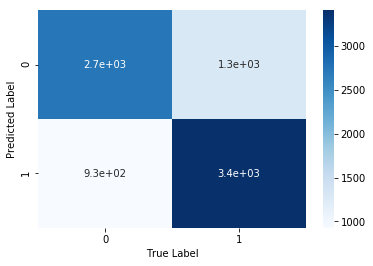

Prediction accuracy on the test set = 0.7335


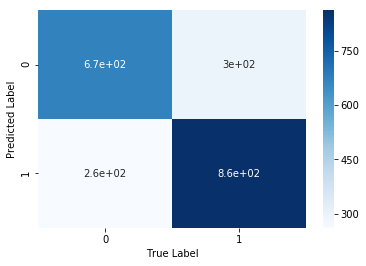

Prediction accuracy on the test set = 0.7337


In [12]:
# Function of plotting confusion matrix of the test result and printing prediction accuracy on test set

def AccuracyReport(y_actual, y_pred):
    cnf_matrix = metrics.confusion_matrix(y_actual, y_pred)
    sn.heatmap(cnf_matrix,annot=True,cmap='Blues')
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.show()

    accuracy_test = accuracy_score(y_actual, y_pred)
    print('Prediction accuracy on the test set =', np.round(accuracy_test,4))

AccuracyReport(y_train, train_pred)
AccuracyReport(y_test, test_pred)

From above, the prediction accuracy on the testing data of our model is around 73.37%.

The global and local interpretability of our model is demonstrated as follows.

First, we investigate the variable importance of the model.

### Step 4: Global Interpretability of the model effects

In [13]:
# (1) Variable importance evaluation
perm = PermutationImportance(gam, scoring='f1', random_state=20190009).fit((x_train.loc[:,features]), y_train)
eli5.show_weights(perm, feature_names=features)

Weight,Feature
0.0571 ± 0.0020,x8
0.0326 ± 0.0064,x1
0.0298 ± 0.0071,x8*x1
0.0262 ± 0.0047,x9
0.0200 ± 0.0029,x5*x1
0.0188 ± 0.0040,x15
0.0181 ± 0.0023,Inq_last_7days
0.0180 ± 0.0018,x20
0.0179 ± 0.0027,x18
0.0163 ± 0.0017,NoData


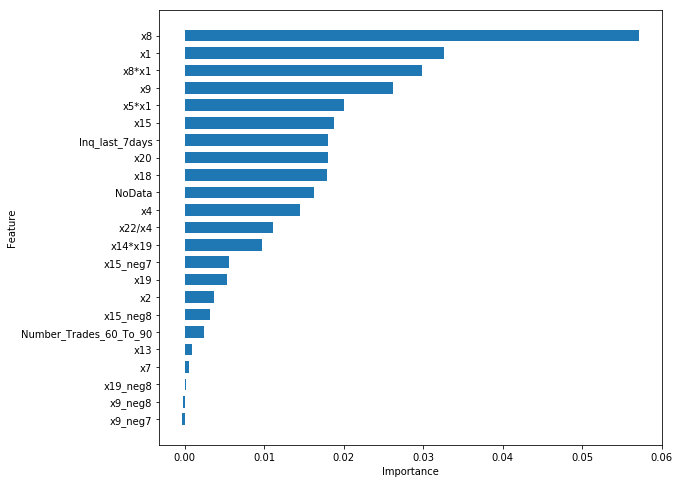

In [14]:
# (2) Bar chart of variable importance in decreasing order
imp_ord = np.argsort(perm.feature_importances_)

plt.figure(figsize=(9,8))
yaxis = np.arange(len(perm.feature_importances_))*1.2
plt.barh(y = yaxis,width = perm.feature_importances_[imp_ord])
plt.yticks(yaxis,x_train.loc[:,features].columns[imp_ord])
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

From the two diagrams above, it is clear that '$x8$' and '$x1$' are the most important variables for prediction in this model. Not only are they important, their interaction effect is also significant. It is because '$x1$' represents the consolidated version of risk markers, so it indicates the risk of trade, and '$x8$' is the percent of trades that never go delinquent, which reflects the quality of credit history.

Some of the other important features include '$x9$' and '$x5*x1$', which also reflects the quality of credit history. '$x15$' and 'Inq_last_7days', which are related to inquiry, are also important. Besides, '$x20$' and '$x18$', which is about revolving trades, are discovered to be influential.  Note that 'NoData' is an essential features as it helps determine the RiskFlag of records with empty data.

After understanding the feature importance, we continue to look at how the involved variables affect the final prediction by creating a partial dependence plot.

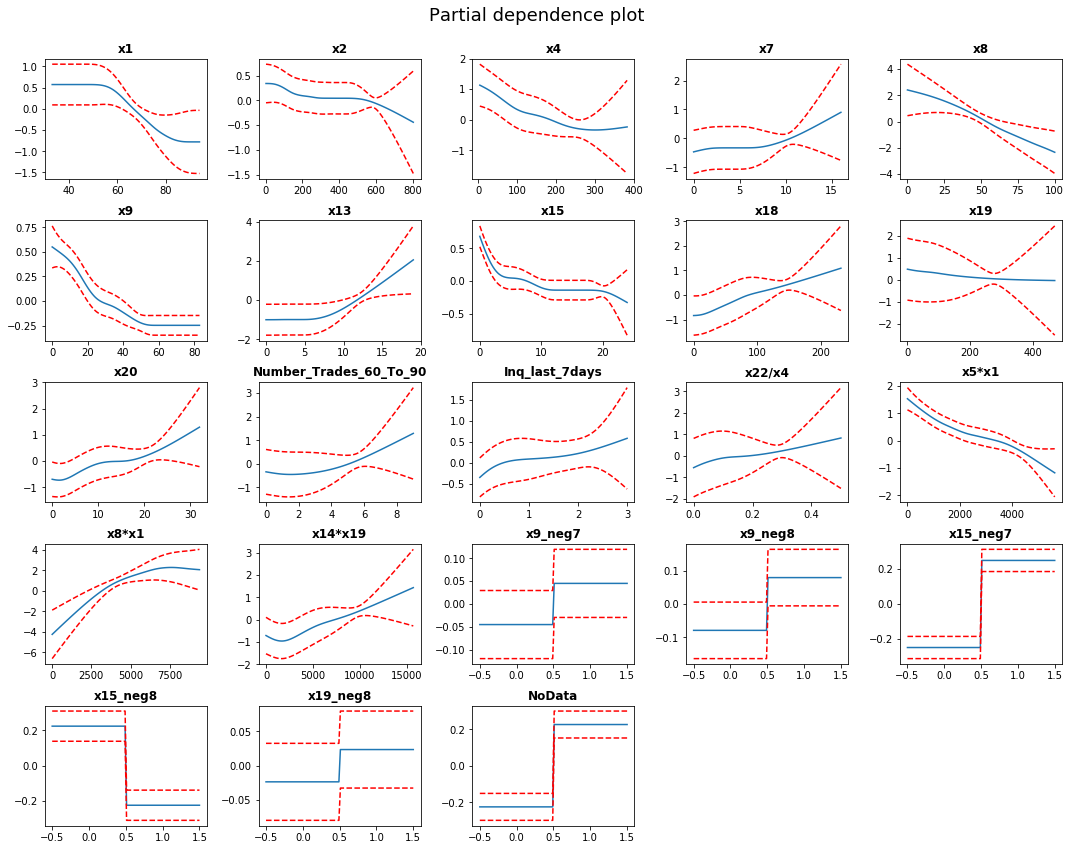

In [15]:
# (3) Partial Dependence Plot (PDP) Generation
fig, axs = plt.subplots(5,5,figsize=(15,12))
names = (x_train.iloc[:,features_idx]).columns
m = 0
n = 0
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    axs[m,n].plot(XX[:, term.feature], pdep)
    axs[m,n].plot(XX[:, term.feature], confi, c='r', ls='--')
    axs[m,n].set_title(names[i], fontweight="bold")
    if (n!=4):
        n = n + 1
    else:
        n = 0
        m = m + 1

plt.suptitle('Partial dependence plot', fontsize=18)
fig.delaxes(axs[4,3])
fig.delaxes(axs[4,4])
plt.tight_layout()
plt.subplots_adjust(top=0.92)

plt.show()

The above partial dependence plot shows the marginal effect of the features involved on the predicted outcome of the GAM model. By looking at this plot, it is easy to tell how the probability of having a 'Bad' Riskflag changes as one of the variables varies, assuming that other variables are kept constant.

To demonstrate how we interpret the model, we pick the some features of importance:

First, the bad probability decreases as $x1$ increases. The same goes for $x8$. However, the probability increases as $x8*x1$ increases. Whether raising the values of these variables will have a positive or negative effect on the probability depends on the values of other variables. This shall be explored locally. However, as $x8$ and $x1$ has more importance than $x8*x1$ from the variable importance chart above, $x8$ and $x1$ probably have a negative effect on the probability. This matches our intuition.

Second, '$x9$' represents the number of months since the most recent delinquency. The graph of $x9$ is monotonically decreasing, and it appears to be like a piecewise linear function, although not exactly. The whole domain (approximately $[0,80]$) can be roughly cut into $[0,20)$,$[20,50)$ and $[50,80]$. Within the first interval, the slope is the steepest, meaning that a slight increase of the value of $x9$ can induce a significant drop in the probability of having a 'Bad' RiskFlag. However, within the second interval, the drop is less significant. In the third interval, no drop is observed. This implies that it is essential not to be delinquent in the last 20 months, and whether delinquency ever occurs or not does not matter, as long as no delinquency occurs recently.

Third, '$x15$', which represents the number of months since most recent inquiries (excluding the last 7 days), can be interpreted similarly as '$x9$'. A steep decreasing slope is observed around $[0,3]$, and the slope is flattened as $x15$ increases. The slope becomes steep again after the value reaches 20. This happens probably due to the existence of outliers. However, in the normal range, we can conclude that it is important not to create inquiry within 3 months in order to have a good credit risk.

We also generate an individual conditional expectation (ICE) plot to verify the above result.

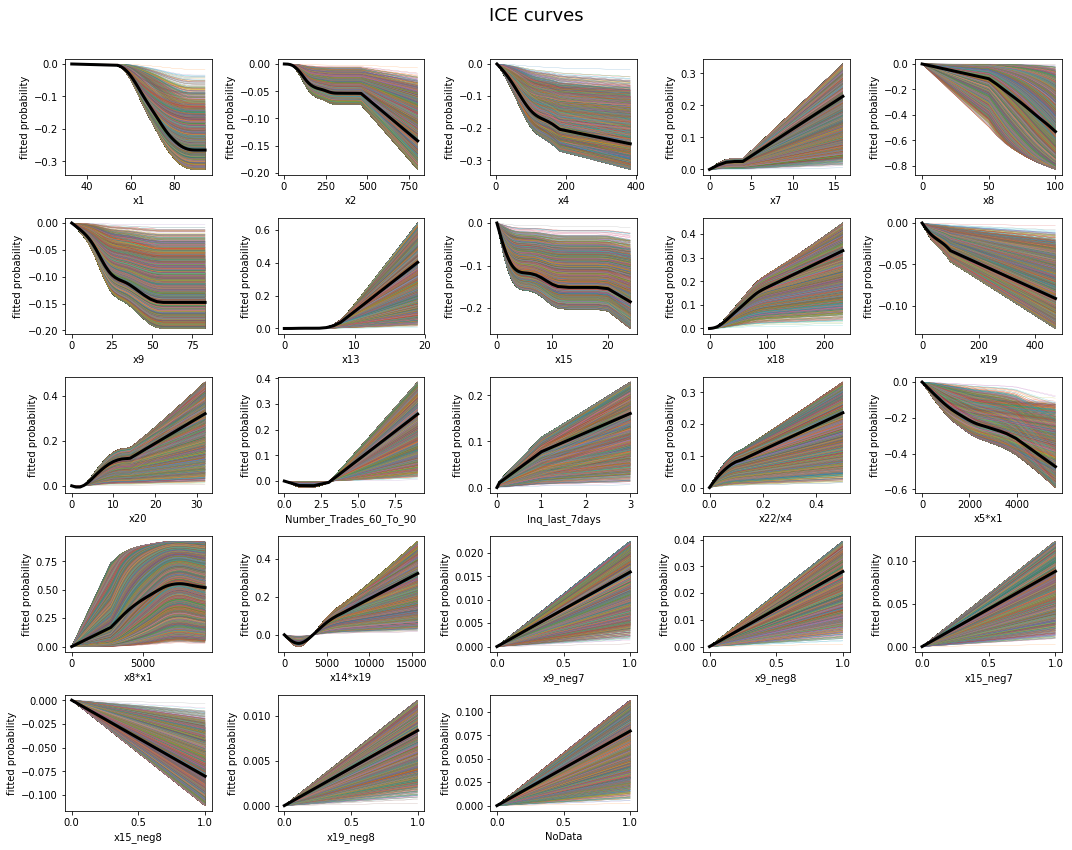

In [16]:
# (4) Individual Conditional Expectation (ICE) plot

# Prepare icebox packages and functions
def __get_quantiles(x):
    return np.greater.outer(x, x).sum(axis=1) / x.size

icebox.__get_quantiles = __get_quantiles

def pred_fun(X_train):
    return gam.predict_proba(X_train)

# Produce ICE plot
fig, axs = plt.subplots(5, 5, figsize=(15, 12))

for i, ax in enumerate(axs.flat):
    if (i==len(features)):
        break
    ice_df = icebox.ice((x_train.loc[:,features]), column=x_train.loc[:,features].columns[i],
                        predict=pred_fun, num_grid_points=100)

    icebox.ice_plot(ice_df, linewidth=0.15, plot_pdp=True,
                    pdp_kwargs={'c': 'k', 'linewidth': 3}, centered=True, ax=ax)
    ax.set_xlabel(x_train.loc[:,features].columns[i])
    ax.set_ylabel('fitted probability')

plt.suptitle('ICE curves', fontsize=18)
fig.delaxes(axs[4,3])
fig.delaxes(axs[4,4])
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

From the ICE plot, most of the curves of individual instances follow closely as the curve of average instance. This result agrees with the previous result in the PDP generation.

After interpreting the model globally, we move on to demonstrate the local interpretability of our model. Only SHAP is used in interpreting the local situation of the model because PyGAM, which is the package used for building our GAM model, is not supported by LIME currently.




### Step 5: Local Interpretability of the model effects

In [17]:
# (1) SHapley Additive exPlanations (SHAP)

# Apply SHAP package
shap.initjs()

# Generate kernel explainer for the model
explainer = shap.KernelExplainer(gam.predict_proba, shap.kmeans(x_test.loc[:,features], 10))
shap_values = explainer.shap_values(x_test.loc[:,features])

The summary plot of SHAP values are generated as follows:

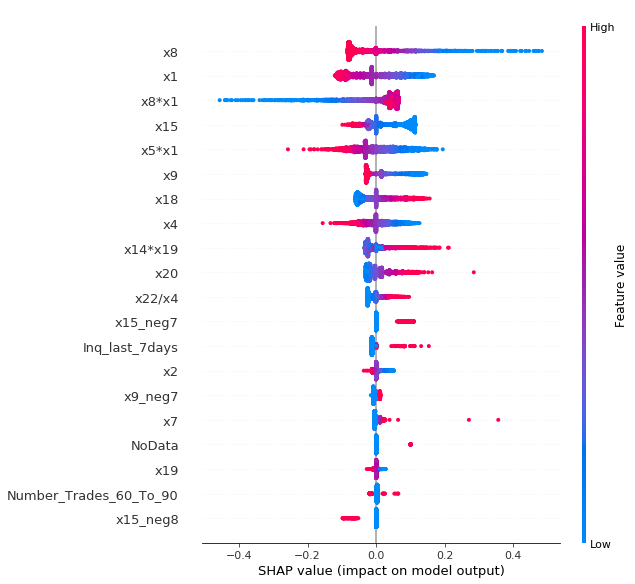

In [19]:
# Generate the dot-style chart of SHAP value, which indicates the variable importance
shap.summary_plot(shap_values, x_test.loc[:,features].values, feature_names=features)

From the summary plot of SHAP value, again we have found out that '$x8$', '$x1$' and '$x8*x1$' are the most influential factors in this model. Neglecting the interaction effect, the higher the values of '$x8$' and '$x1$', the lower the SHAP value, so the predicted bad probability is also lower. After the top 3, the order of importance in this plot is a bit different from that in the previous feature importance chart, but it is in general similar.

To investigate the local interpretability of the model, two datapoints are selected. The i-th datapoint is a 'Good' point, while the j-th datapoint is a 'Bad' point.

In [20]:
# The index of the two datapoints for investigation
i = 1046
j = 1494

In [21]:
# Print the details of i-th datapoint
df_test.iloc[[i],:]

,RiskFlag,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23
6951,0,68,146,2,75,36,3,3,92,12,...,41,16,0,0,3,92,4,3,0,58


In [22]:
# Print the details of j-th datapoint
df_test.iloc[[j],:]

,RiskFlag,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23
2564,1,61,358,6,140,26,1,0,67,25,...,26,-7,2,2,76,-8,10,1,3,69


We first look at the i-th datapoint. Its forceplot is generated to show the shap values of the variables.

In [23]:
# Generate forceplot for the i-th datapoint
shap.initjs()
shap.force_plot(base_value=explainer.expected_value, shap_values=shap_values[i],
                features=x_test.iloc[i,features_idx], feature_names=features)

The above forceplot shows that the i-th datapoint has a predicted probability of 0.38 and hence the predicted RiskFlag is 'Good'. This matches the actual outcome.

The most influential variables in this case is '$x9$', followed by '$x5*x1$'. We shall investigate how the probability will change as these two variables are perturbed. Since the second variable involved two primitive variables '$x1$' and '$x5$', a 3d plot will be generated to visualize the perturbation.

In [24]:
# Define a function to generate the probabilities when one variable is perturbed
def Proba_array(X, x, k):
    Y = np.zeros(X.shape[0])
    for s in range(X.shape[0]):
            x_test_copy=x_test.iloc[[k],features_idx].copy()
            x_test_copy[x] = X[s]
            Y[s] = gam.predict_proba(x_test_copy.values)
    return Y

In [25]:
# Define a function to generate the probabilities when two variables are perturbed
# The definition of this function allows the pertubation of two variables as well as their interaction term
def Proba_meshgrid(X, Y, x, y, z, k):
    Z = np.zeros((X.shape[0], X.shape[1]))
    for s in range(X.shape[0]):
        for t in range(X.shape[1]):
            x_test_copy=x_test.iloc[[k],features_idx].copy()
            if (x!=''):
                x_test_copy[x] = X[s,t]
            if (y!=''):
                x_test_copy[y] = Y[s,t]
            if (z!=''):
                x_test_copy[z] = X[s,t]*Y[s,t]
            Z[s,t] = gam.predict_proba(x_test_copy.values)
    return Z

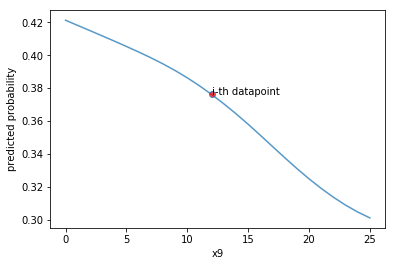

In [26]:
# Local Interpretability of the i-th datapoint (with predicted RiskFlag = 'Good')
# Pertubation of x9
x9_range_i = np.linspace(0,25,26)
prob = Proba_array(x9_range_i, 'x9', i)

fig = plt.figure()
ax = fig.gca()
markers_on = list(df_test.iloc[[i],[9]].values)
ax.plot(x9_range_i, prob, "-o", markerfacecolor="r", alpha = 0.75, markevery=markers_on)
ax.annotate('i-th datapoint', (df_test.iloc[[i],[9]].values, float(gam.predict_proba(x_test.iloc[[i],features_idx]))))
fig.add_axes(ax)
ax.set_xlabel('x9')
ax.set_ylabel('predicted probability')
plt.show()

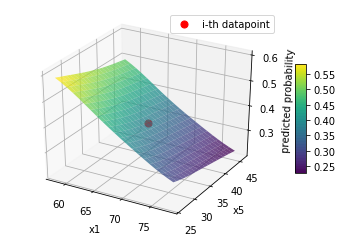

In [27]:
# Local Interpretability of the i-th datapoint (with predicted RiskFlag = 'Good')
# Pertubation of x1 and x5
x1_range_i = np.linspace(58,78,21)
x5_range_i = np.linspace(26,46,21)
X1_i, X5_i = np.meshgrid(x1_range_i, x5_range_i)
prob = Proba_meshgrid(X1_i, X5_i, 'x1', '', 'x5*x1', i)

fig = plt.figure()
ax = fig.gca(projection='3d')
dot_i = ax.scatter(df_test.iloc[[i],[1]],df_test.iloc[[i],[5]], float(gam.predict_proba(x_test.iloc[[i],features_idx])),s=50,c='r')
ax.legend([dot_i], ['i-th datapoint'], numpoints = 1)
surf = ax.plot_surface(X1_i, X5_i, prob, alpha = 0.75, cmap='viridis')

ax.set_xlabel('x1')
ax.set_ylabel('x5')
ax.set_zlabel('predicted probability')
fig.add_axes(ax)
fig.colorbar(surf, shrink=0.5, aspect=10)
ax.view_init(30, -60)
plt.show()

From the two plots above, we can see at the i-th datapoint, how the predicted probability will change as the two variables change, including the direction and magnitude of change. Without perturbation, the predicted RiskFlag is 'Good'. As $x9$ decreases, the probability of getting a 'Bad' RiskFlag increases. However, even if $x9$ is decreased to $0$, the bad probability is still lower than $0.5$. On the other hand, if $x1$ and $x5$ both decrease, the bad probability will increase (the datapoint will move to the yellowish-green region).

The following is the interpretation of the j-th datapoint. Again, its forceplot is generated as follows:

In [28]:
# Generate forceplot for the j-th datapoint
shap.initjs()
shap.force_plot(base_value=explainer.expected_value, shap_values=shap_values[j],
                features=x_test.iloc[j,features_idx], feature_names=features)

The above forceplot shows that the j-th datapoint has a predicted probability of 0.77 and hence the predicted RiskFlag is 'Bad'. This also matches the actual outcome.

The most influential variables in this case is '$x8$', followed by '$x8*x1$', '$x1$'. We will investigate how the probability will change as these variables are perturbed. The perturbation of the all three variables shall be shown in one single 3d plot.

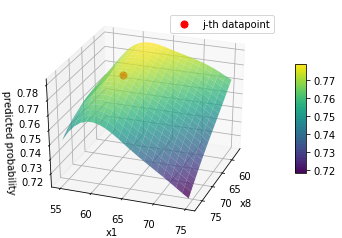

In [29]:
# Local Interpretability of the j-th datapoint (with predicted RiskFlag = 'Bad')
# Pertubation of x1 and x8

x8_range_j = np.linspace(57,77,21)
x1_range_j = np.linspace(55,75,21)
X8_j, X1_j = np.meshgrid(x8_range_j, x1_range_j)
prob = Proba_meshgrid(X8_j, X1_j, 'x8', 'x1', 'x8*x1', j)

fig = plt.figure()
ax = fig.gca(projection='3d')
dot_j = ax.scatter(df_test.iloc[[j],[8]],df_test.iloc[[j],[1]], float(gam.predict_proba(x_test.iloc[[j],features_idx])),s=50,c='r')
ax.legend([dot_j], ['j-th datapoint'], numpoints = 1)
surf = ax.plot_surface(X8_j, X1_j, prob, alpha = 0.75, cmap='viridis')

ax.set_xlabel('x8')
ax.set_ylabel('x1')
ax.set_zlabel('predicted probability')
fig.add_axes(ax)
fig.colorbar(surf, shrink=0.5, aspect=10)
ax.view_init(30, 20)
plt.show()

Without perturbation, the predicted RiskFlag is 'Bad'. From the above graph, it is clear that if $x1$ and $x8$ increase, then there will be a drop in bad probability (the datapoint will move to the dark-blue region). In the figure, the probability seems to drop when $x1$ decreases and $x8$ increases. However, we believe that this change is unrealistic as an increase in $x8$ means an increase in the percentage of trades that never goes delinquent, so this will cause $x1$, the consolidated version of risk marker, to increase simultaneously. Therefore, we believe that this is not an issue.

### Conclusion

In summary, our group produces a Generalized Additive Model for the HELOC dataset with testing accuracy = 73.37%. Globally, it is found that $x1$ and $x8$ have heavy weightings in the feature importance, and the influences induced by different variables have been demonstrated using partial dependence plot. Two datapoints have been selected for exploring the local interpretability of the model.